In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from em import generate_data, run_gmm

In [5]:
"""
1. Generate synthetic data from a 3-mode gaussian mixture model
"""

x1_random = generate_data(10000, num_modes=1)
x2_random = generate_data(10000, num_modes=2)
x3_random = generate_data(10000, num_modes=3)

Means = 1, Vars = 3, Weights = 1.0
Means = 61, 99, Vars = 2, 5, Weights = 0.38, 0.62
Means = 8, 77, 84, Vars = 5, 1, 1, Weights = 0.57, 0.3, 0.13


Means = 0, 5, 10, Vars = 1, 1, 1, Weights = 0.2, 0.5, 0.3


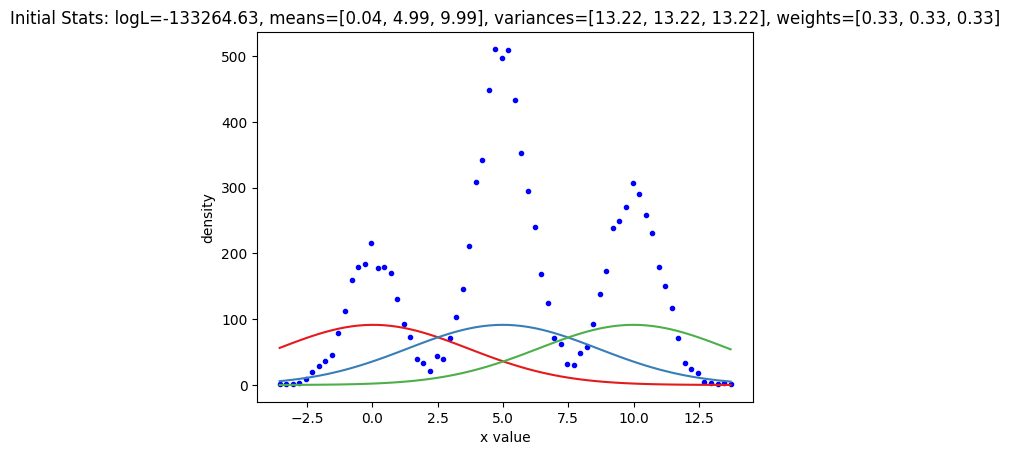

/Users/vivian/sv_gmm/em.py:333: UserWarning: Maximum number of iterations reached without logL convergence
  warnings.warn(


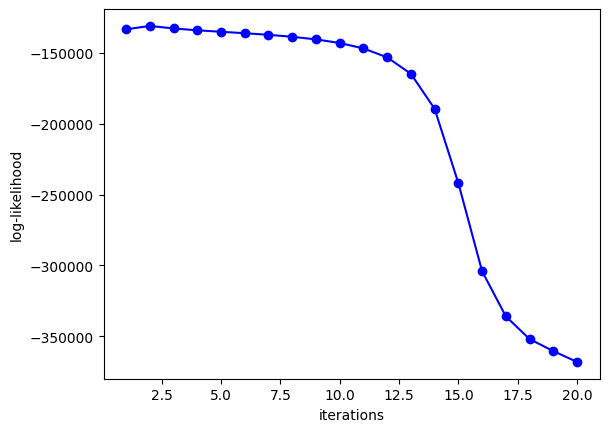

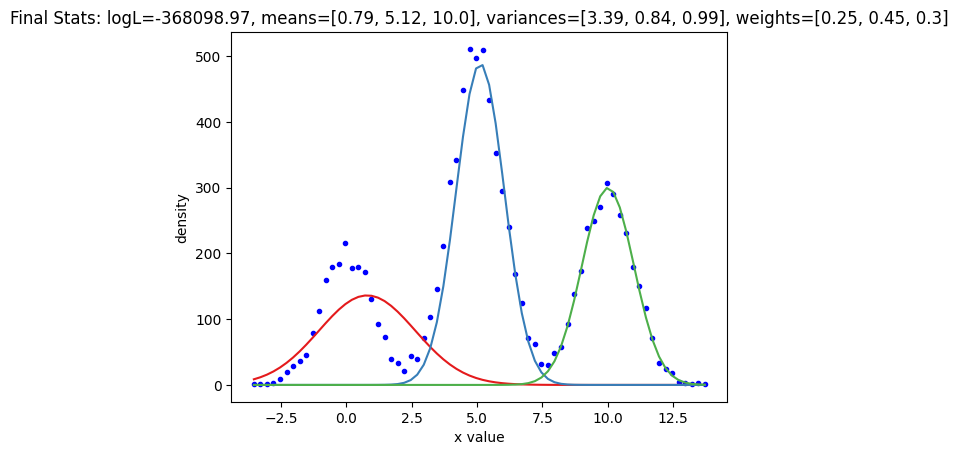

logL: -368098.97, num_modes: 3, aic: 736213.95

Number of SVs: 3
logL=-368098.97, means=[0.79, 5.12, 10.0], variances=[3.39, 0.84, 0.99], weights=[0.25, 0.45, 0.3]


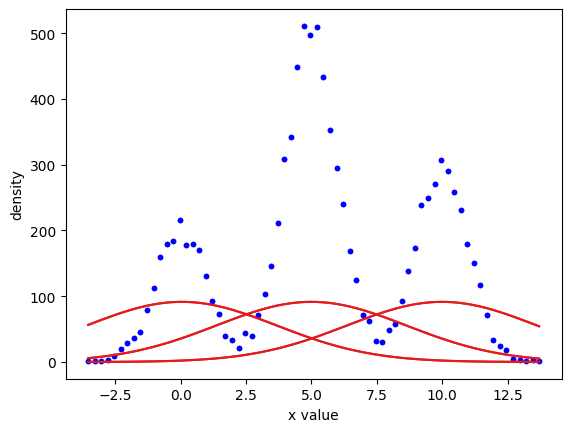

In [6]:
"""
2. Estimate the parameters via EM
"""

# x = generate_data(10000, mode_means=np.array([98, 83]), mode_variances=np.array([3, 2]), weights=np.array([0.62, 0.38]))
x = generate_data(10000, mode_means=np.array([0, 5, 10]), mode_variances=np.array([1, 1, 1]), weights=np.array([0.2, 0.5, 0.3]))
# x = generate_data(10000, mode_means=np.array([41, 68, 60]), mode_variances=np.array([3, 5, 5]), weights=np.array([0.45, 0.14, 0.41]))
run_gmm(x)